In [ ]:
!pip install numpy scipy filterpy

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from scipy.spatial.transform import Rotation as R

class LeggedRobotUKF:
    def __init__(self, dt):
        self.dt = dt

        # UKF setup: 7 state dimensions (position + quaternion), 7 measurement dimensions (position + quaternion)
        points = MerweScaledSigmaPoints(n=7, alpha=0.1, beta=2.0, kappa=0)
        self.ukf = UKF(dim_x=7, dim_z=7, fx=self.predict_state, hx=self.hx,dt=dt, points=points)

        # Initial state: Position and quaternion
        self.ukf.x = np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0])  # [p_x, p_y, p_z, q_w, q_x, q_y, q_z]

        # Covariance matrices
        self.ukf.P *= 0.01  # Initial uncertainty
        self.ukf.Q *= 0.1  # Process noise
        self.ukf.R *= 0.1  # Measurement noise

    def predict_state(self, x, dt, u):
        p = x[0:3]  # Position
        q = R.from_quat(x[3:7])  # Quaternion

        # Decompose control input (velocity and angular velocity)
        v = u[0:3]  # Linear velocity
        omega = u[3:6]  # Angular velocity

        # Update position
        p += v * dt

        # Update orientation using angular velocity
        delta_q = R.from_rotvec(omega * dt)
        q = q * delta_q

        # Return updated state
        return np.hstack((p, q.as_quat()))

    def hx(self, x):
        # Measurement function: directly return the predicted position and quaternion
        return x

    def update(self, z, u):
        # Predict step
        self.ukf.predict(u=u)

        # Update step with the measurement (position and quaternion)
        self.ukf.update(z)

    def get_state(self):
        return self.ukf.x

# Example test function
def test_legged_robot_ukf():
    dt = 0.1
    robot_ukf = LeggedRobotUKF(dt)

    # Example control inputs (simulated) [v_x, v_y, v_z, omega_x, omega_y, omega_z]
    control_inputs = [
        np.array([0.1, 0.0, 0.0, 0.01, 0.01, 0.0]),
        np.array([0.2, 0.1, 0.0, 0.02, 0.01, 0.01]),
        np.array([0.3, 0.1, 0.0, 0.01, 0.02, 0.01])
    ]

    # Simulated measurements [p_x, p_y, p_z, q_w, q_x, q_y, q_z]
    measurements = [
        np.array([0.01, 0.02, 0.0, 0.9999, 0.01, 0.0, 0.0]),
        np.array([0.03, 0.04, 0.0, 0.9998, 0.02, 0.0, 0.0]),
        np.array([0.06, 0.07, 0.0, 0.9997, 0.03, 0.0, 0.0])
    ]

    # Run the UKF through predictions and updates
    for i in range(len(control_inputs)):
        robot_ukf.update(measurements[i], control_inputs[i])
        predicted_state = robot_ukf.get_state()
        print(f"Estimated state after step {i + 1}: {predicted_state}")

# Run the test
test_legged_robot_ukf()


Estimated state after step 1: [ 1.00000000e-02  1.81818182e-03 -1.25865529e-21  9.85074755e-01
  9.08512765e-04  4.47116357e-04 -4.47116357e-04]
Estimated state after step 2: [ 3.00000000e-02  2.65217391e-02  3.10427347e-18  8.92864375e-01
  1.06986328e-02  3.49137018e-04 -5.32656981e-04]
Estimated state after step 3: [ 6.00000000e-02  5.67241379e-02 -5.68982891e-17  8.91597603e-01
  2.23440774e-02  3.31737399e-04 -2.67397035e-04]


In [ ]:
# Simulate robot's true state over time
def simulate_robot_motion(T, dt, control_inputs):
    time_steps = int(T / dt)
    states = []

    # Initial state: [p_x, p_y, p_z, q_w, q_x, q_y, q_z]
    state = np.array([0.0, 0.0, 0.0,  # Position
                      1.0, 0.0, 0.0, 0.0])  # Quaternion (no rotation initially)

    for i in range(time_steps):
        u = control_inputs[i]

        # Update position with velocity
        position = state[0:3] + u[0:3] * dt  # Positions (p_x, p_y, p_z)

        # Update quaternion with angular velocity
        delta_rotation = R.from_rotvec(u[3:6] * dt)
        orientation = R.from_quat(state[3:7]) * delta_rotation
        state[3:7] = orientation.as_quat()

        # Update state
        state[0:3] = position

        # Store the state
        states.append(state.copy())

    return np.array(states)

# Generate control inputs
def generate_control_inputs(T, dt):
    time_steps = int(T / dt)
    control_inputs = []

    for _ in range(time_steps):
        v_x = 0.5 + np.random.uniform(-0.1, 0.1)  # Forward velocity with some randomness
        v_y = np.random.uniform(-0.05, 0.05)  # Lateral velocity with randomness
        v_z = 0.0  # No vertical velocity

        omega_x = 0.01 + np.random.uniform(-0.005, 0.005)  # Slight roll with randomness
        omega_y = 0.01 + np.random.uniform(-0.005, 0.005)  # Slight pitch with randomness
        omega_z = 0.02 + np.random.uniform(-0.01, 0.01)  # Slight yaw (turning) with randomness

        control_inputs.append(np.array([v_x, v_y, v_z, omega_x, omega_y, omega_z]))

    return np.array(control_inputs)

# Generate noisy measurements
def generate_noisy_measurements(true_states, noise_std):
    noisy_measurements = true_states[:, 0:7] + np.random.normal(0, noise_std, true_states[:, 0:7].shape)
    return noisy_measurements

In [ ]:
class LeggedRobotUKF:
    def __init__(self, dt):
        self.dt = dt

        # UKF setup: 7 state dimensions (position + quaternion), 7 measurement dimensions (position + quaternion)
        points = MerweScaledSigmaPoints(n=7, alpha=0.1, beta=2.0, kappa=0)
        self.ukf = UKF(dim_x=7, dim_z=7, fx=self.predict_state, hx=self.hx,dt=dt, points=points)

        # Initial state: Position and quaternion
        self.ukf.x = np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0])  # [p_x, p_y, p_z, q_w, q_x, q_y, q_z]

        # Covariance matrices
        self.ukf.P *= 0.01  # Initial uncertainty
        self.ukf.Q *= 0.1  # Process noise
        self.ukf.R *= 0.1  # Measurement noise

    def predict_state(self, x, dt, u):
        p = x[0:3]  # Position
        q = R.from_quat(x[3:7])  # Quaternion

        # Decompose control input (velocity and angular velocity)
        v = u[0:3]  # Linear velocity
        omega = u[3:6]  # Angular velocity

        # Update position
        p += v * dt

        # Update orientation using angular velocity
        delta_q = R.from_rotvec(omega * dt)
        q = q * delta_q

        # Return updated state
        return np.hstack((p, q.as_quat()))

    def hx(self, x):
        # Measurement function: directly return the predicted position and quaternion
        return x

    def update(self, z):
        # Update step with the measurement (position and quaternion)
        self.ukf.update(z)

    def get_state(self):
        return self.ukf.x

In [ ]:
# Simulation parameters
T = 50.0  # Total time (seconds)
dt = 0.1  # Time step (seconds)
noise_std = 0.05  # Standard deviation of sensor noise

# Generate control inputs
control_inputs = generate_control_inputs(T, dt)

# Simulate the true robot motion
true_states = simulate_robot_motion(T, dt, control_inputs)

# Generate noisy measurements
noisy_measurements = generate_noisy_measurements(true_states, noise_std)

# Initialize the UKF
robot_ukf = LeggedRobotUKF(dt)

# Run the UKF on the noisy measurements
ukf_estimates = []
for i in range(len(noisy_measurements)):
    # Predict step using the UKF's predict method, which internally calls predict_state
    robot_ukf.ukf.predict(u=control_inputs[i])

    # Update step with the measurement
    robot_ukf.update(z=noisy_measurements[i])

    # Store the UKF estimate
    ukf_estimates.append(robot_ukf.get_state())

ukf_estimates = np.array(ukf_estimates)

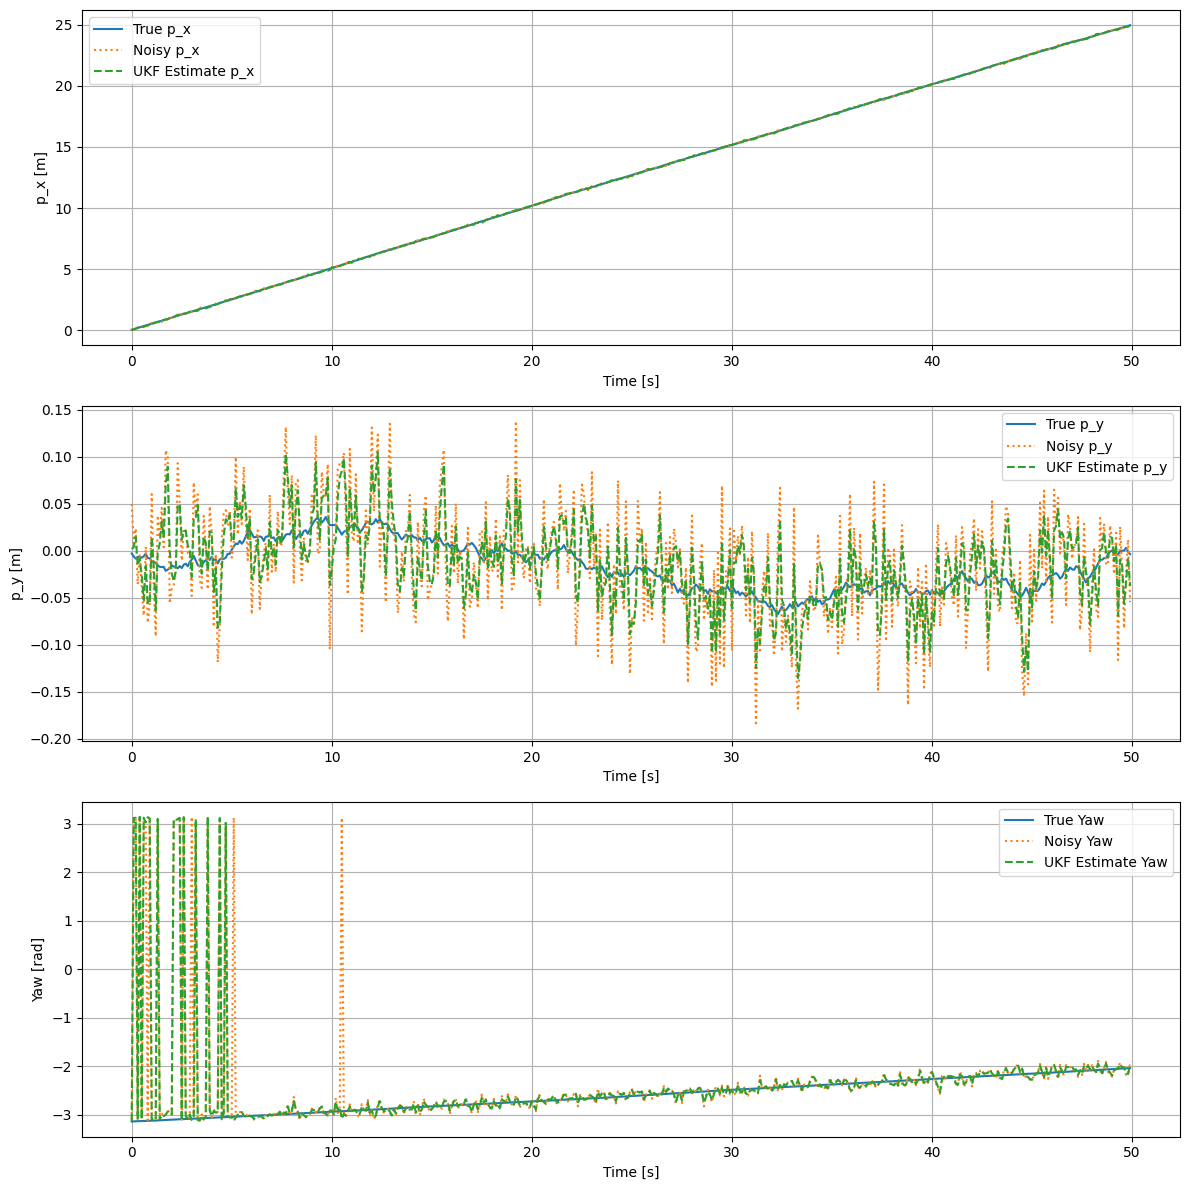

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

time = np.arange(0, T, dt)

plt.figure(figsize=(12, 12))

# Plot position (p_x, p_y, p_z)
plt.subplot(3, 1, 1)
plt.plot(time, true_states[:, 0], label='True p_x')
plt.plot(time, noisy_measurements[:, 0], label='Noisy p_x', linestyle='dotted')
plt.plot(time, ukf_estimates[:, 0], label='UKF Estimate p_x', linestyle='dashed')
plt.xlabel('Time [s]')
plt.ylabel('p_x [m]')
plt.legend()
plt.grid()

# Plot position (p_y)
plt.subplot(3, 1, 2)
plt.plot(time, true_states[:, 1], label='True p_y')
plt.plot(time, noisy_measurements[:, 1], label='Noisy p_y', linestyle='dotted')
plt.plot(time, ukf_estimates[:, 1], label='UKF Estimate p_y', linestyle='dashed')
plt.xlabel('Time [s]')
plt.ylabel('p_y [m]')
plt.legend()
plt.grid()

# Plot orientation (yaw angle)
yaw_true = R.from_quat(true_states[:, 3:7]).as_euler('zxy')[:, 0]
yaw_noisy = R.from_quat(noisy_measurements[:, 3:7]).as_euler('zxy')[:, 0]
yaw_ukf = R.from_quat(ukf_estimates[:, 3:7]).as_euler('zxy')[:, 0]

plt.subplot(3, 1, 3)
plt.plot(time, yaw_true, label='True Yaw')
plt.plot(time, yaw_noisy, label='Noisy Yaw', linestyle='dotted')
plt.plot(time, yaw_ukf, label='UKF Estimate Yaw', linestyle='dashed')
plt.xlabel('Time [s]')
plt.ylabel('Yaw [rad]')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from scipy.spatial.transform import Rotation as R

class LeggedRobotUKF:
    def __init__(self, dt):
        # Time step
        self.dt = dt

        # Initialize UKF with 10 dimensions for the state and 7 dimensions for the measurement
        points = MerweScaledSigmaPoints(n=10, alpha=0.1, beta=2.0, kappa=0)
        self.ukf = UKF(dim_x=10, dim_z=7, dt=self.dt, fx=self.predict_state, hx=self.hx, points=points)

        # Initialize state vector [p_x, p_y, p_z, q_w, q_x, q_y, q_z, v_x, v_y, v_z]
        self.ukf.x = np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

        # Set process and measurement noise covariance matrices
        self.ukf.P *= 0.01  # Initial uncertainty
        self.ukf.Q *= 0.1  # Process noise
        self.ukf.R *= 0.1  # Measurement noise

        # Override the residual_z function for custom measurement residuals
        self.ukf.residual_z = self.residual_z

    def motion_model(self, t, state, u):
        p = state[0:3]  # Position
        q = R.from_quat(state[3:7])  # Orientation as quaternion
        v = state[7:10]  # Velocity

        # Decompose control input
        omega = u[3:6]  # Angular velocity

        # Update quaternion with angular velocity
        dq = q * R.from_rotvec(omega * self.dt)  # Quaternion update

        # Combine the derivatives
        derivatives = np.hstack((v, dq.as_quat(), u[0:3]))  # Positions, quaternions, velocities

        return derivatives

    def predict_state(self, x, dt, u):
        sol = solve_ivp(self.motion_model, [0, dt], x, args=(u,), method='RK45', t_eval=[dt])
        return sol.y.flatten()

    def hx(self, x):
        # Measurement function: only returns position and orientation
        return x[0:7]

    def residual_z(self, z, z_pred):
        # Custom residual function for measurements
        dz = np.zeros_like(z)
        dz[0:3] = z[0:3] - z_pred[0:3]  # Position residuals

        # Calculate the quaternion residuals and convert to rotation vector
        q_residual = R.from_quat(z[3:7]).inv() * R.from_quat(z_pred[3:7])
        dz[3:6] = q_residual.as_rotvec()  # Store rotation vector in dz[3:6]
        dz[6] = 0  # Zero out the last component (since rotation vector is 3D)

        return dz

    def update(self, z):
        self.ukf.update(z)

    def predict(self, u):
        self.ukf.predict(u=u)

    def get_state(self):
        return self.ukf.x

# Sample data testing
def test_legged_robot_ukf():
    # Initialize the LeggedRobotUKF class
    dt = 0.1
    robot_ukf = LeggedRobotUKF(dt)

    # Example control inputs [v_x, v_y, v_z, omega_x, omega_y, omega_z]
    control_inputs = [
        np.array([0.1, 0.0, 0.0, 0.01, 0.01, 0.0]),
        np.array([0.2, 0.1, 0.0, 0.02, 0.01, 0.01]),
        np.array([0.3, 0.1, 0.0, 0.01, 0.02, 0.01])
    ]

    # Simulated measurements (position and quaternion)
    measurements = [
        np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]),
        np.array([0.01, 0.02, 0.0, 0.9999, 0.01, 0.0, 0.0]),
        np.array([0.02, 0.03, 0.0, 0.9998, 0.02, 0.0, 0.0])
    ]

    # Run the UKF through predictions and updates
    for i in range(len(control_inputs)):
        # Predict step
        robot_ukf.predict(control_inputs[i])

        # Update step
        robot_ukf.update(measurements[i])
        predicted_state = robot_ukf.get_state()
        # Print the estimated state
        print(f"Estimated state after step {i + 1}:")
        print(predicted_state)
        print("Difference", predicted_state[0:7] - measurements[i])

# Run the test
test_legged_robot_ukf()


Estimated state after step 1:
[ 4.54132607e-04 -1.26047119e-17 -1.26047119e-17  1.09850110e+00
  3.96225324e-18  3.68558636e-05 -3.68558636e-05  9.99545867e-03
  1.26047119e-19  1.26047119e-19]
Difference [ 4.54132607e-04 -1.26047119e-17 -1.26047119e-17  9.85010996e-02
  3.96225324e-18  3.68558636e-05 -3.68558636e-05]
Estimated state after step 2:
[ 6.41428331e-03  1.07343631e-02  5.93477687e-17  1.18508732e+00
  9.38393145e-03  1.76140767e-05 -2.69732573e-05  3.04224228e-02
  1.11032925e-02 -7.06675066e-18]
Difference [-3.58571669e-03 -9.26563694e-03  5.93477687e-17  1.85187319e-01
 -6.16068549e-04  1.76140767e-05 -2.69732573e-05]
Estimated state after step 3:
[ 1.64633681e-02  2.30955380e-02  5.96979740e-17  1.27132930e+00
  2.22749252e-02  2.22380229e-05 -1.52635654e-05  6.13628001e-02
  2.29391634e-02  3.17180720e-16]
Difference [-3.53663195e-03 -6.90446197e-03  5.96979740e-17  2.71529304e-01
  2.27492525e-03  2.22380229e-05 -1.52635654e-05]


In [ ]:
T = 10.0  # Total time (seconds)
dt = 0.1  # Time step (seconds)
noise_std = 0.05  # Standard deviation of sensor noise

# Generate control inputs
control_inputs = generate_control_inputs(T, dt)

# Simulate true robot motion
true_states = simulate_robot_motion(T, dt, control_inputs)

# Generate noisy measurements (using only the first 7 elements, i.e., position and quaternion)
noisy_measurements = generate_noisy_measurements(true_states[:, 0:7], noise_std)

# Initialize the UKF
robot_ukf = LeggedRobotUKF(dt)

# Run the UKF on the noisy measurements
ukf_estimates = []
for i in range(len(noisy_measurements)):
    # Predict step
    robot_ukf.predict(u=control_inputs[i])

    # Update step
    robot_ukf.update(noisy_measurements[i])

    # Store the UKF estimate
    ukf_estimates.append(robot_ukf.get_state())

ukf_estimates = np.array(ukf_estimates)


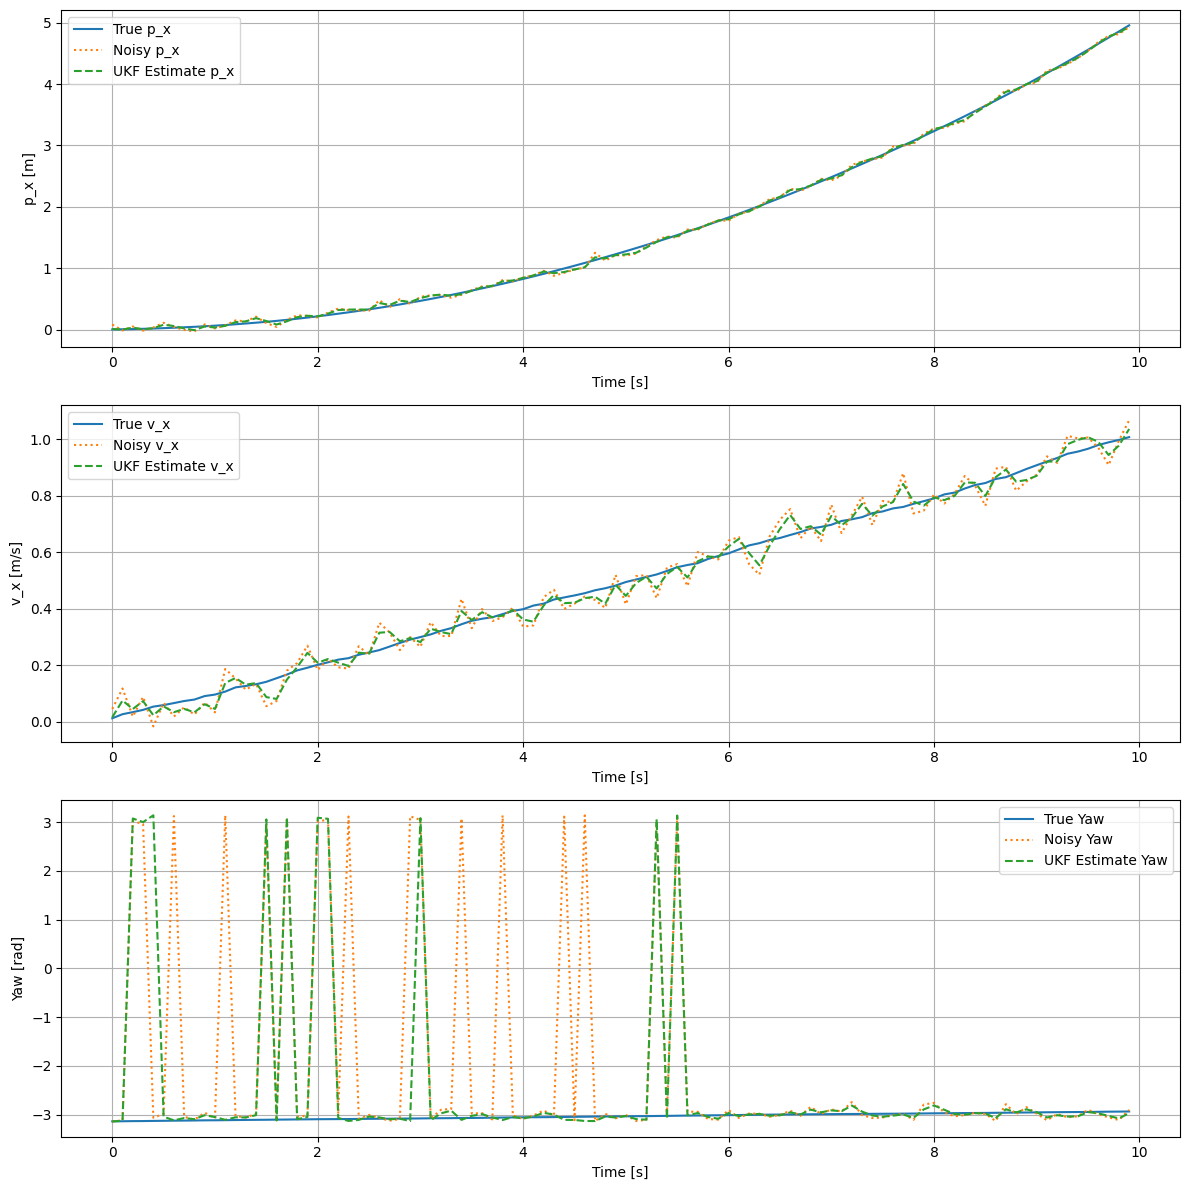

In [ ]:
# Plot the results
time = np.arange(0, T, dt)

plt.figure(figsize=(12, 12))

# Plot position (p_x, p_y, p_z)
plt.subplot(3, 1, 1)
plt.plot(time, true_states[:, 0], label='True p_x')
plt.plot(time, noisy_measurements[:, 0], label='Noisy p_x', linestyle='dotted')
plt.plot(time, ukf_estimates[:, 0], label='UKF Estimate p_x', linestyle='dashed')
plt.xlabel('Time [s]')
plt.ylabel('p_x [m]')
plt.legend()
plt.grid()

# Plot velocity (v_x, v_y, v_z)
plt.subplot(3, 1, 2)
plt.plot(time, true_states[:, 7], label='True v_x')
plt.plot(time, ukf_estimates[:, 7], label='UKF Estimate v_x', linestyle='dashed')
plt.xlabel('Time [s]')
plt.ylabel('v_x [m/s]')
plt.legend()
plt.grid()

# Plot orientation (yaw angle)
yaw_true = R.from_quat(true_states[:, 3:7]).as_euler('zxy')[:, 0]
yaw_noisy = R.from_quat(noisy_measurements[:, 3:7]).as_euler('zxy')[:, 0]
yaw_ukf = R.from_quat(ukf_estimates[:, 3:7]).as_euler('zxy')[:, 0]

plt.subplot(3, 1, 3)
plt.plot(time, yaw_true, label='True Yaw')
plt.plot(time, yaw_noisy, label='Noisy Yaw', linestyle='dotted')
plt.plot(time, yaw_ukf, label='UKF Estimate Yaw', linestyle='dashed')
plt.xlabel('Time [s]')
plt.ylabel('Yaw [rad]')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from scipy.linalg import expm

class LeggedRobotUKF:
    def __init__(self, dt):
        self.dt = dt  # Time step

        # State vector: [position(3), velocity(3), orientation(9), gyro_bias(3), accel_bias(3)]
        self.state_dim = 21
        self.state = np.zeros(self.state_dim)

        # Covariance matrix (state uncertainty)
        self.P = np.eye(self.state_dim) * 0.1  # Initial covariance

        # Process noise covariance (system process uncertainty)
        self.Q = np.eye(self.state_dim) * 0.01  # To be tuned

        # Measurement noise covariance (sensor measurement uncertainty)
        self.R = np.eye(6) * 0.05  # Measurement noise (can be tuned)

        # Define sigma points for UKF
        points = MerweScaledSigmaPoints(n=self.state_dim, alpha=0.1, beta=2.0, kappa=3-self.state_dim)
        self.ukf = UKF(dim_x=self.state_dim, dim_z=6, fx=self.state_transition, hx=self.measurement_function,
                       dt=self.dt, points=points)

        # Initialize UKF parameters
        self.ukf.x = self.state
        self.ukf.P = self.P
        self.ukf.R = self.R
        self.ukf.Q = self.Q

    def state_transition(self, state, dt):
        """
        State transition function for the robot.
        This predicts the next state based on the current state and system dynamics.
        """
        pos, vel, orientation = state[:3], state[3:6], state[6:15].reshape((3, 3))
        gyro_bias, accel_bias = state[15:18], state[18:21]

        # Update position and velocity based on acceleration
        pos += vel * dt
        accel_world = np.dot(orientation, accel_bias)  # Transform accel to world frame
        vel += accel_world * dt

        # Update orientation using gyroscope data
        omega = gyro_bias * dt
        orientation = np.dot(orientation, expm(self.skew_symmetric(omega)))  # Update orientation using matrix exponential

        # Flatten the orientation matrix back to the state vector
        return np.hstack([pos, vel, orientation.flatten(), gyro_bias, accel_bias])

    def measurement_function(self, state):
        """
        Measurement function that transforms state into measurement space.
        Returns the expected measurement given the current state.
        """
        # Expected measurements: [acceleration (3), angular velocity (3)]
        accel_world = np.dot(state[6:15].reshape((3, 3)).T, state[18:21])  # Inverse of orientation to transform back to body frame
        return np.hstack([accel_world, state[15:18]])  # [acceleration, gyro]

    def skew_symmetric(self, omega):
        """Helper function to create a skew-symmetric matrix from a 3D vector (for rotation)."""
        return np.array([
            [0, -omega[2], omega[1]],
            [omega[2], 0, -omega[0]],
            [-omega[1], omega[0], 0]
        ])

    def predict(self):
        """Run the UKF prediction step."""
        self.ukf.predict()

    def update(self, z):
        """Run the UKF update step with sensor measurements."""
        self.ukf.update(z)

    def get_state(self):
        """Return the current estimated state."""
        return self.ukf.x



In [ ]:
ukf = LeggedRobotUKF(dt=dt)
ukf_estimates = np.zeros((time_steps, 21))

# Run the UKF with the generated data
for t in range(time_steps):
    # Get current sensor data (accel and gyro)
    z = sensor_data[t, :]

    # UKF prediction step
    ukf.predict()

    # UKF update step with new sensor data
    ukf.update(z)

    # Store the current state estimate
    ukf_estimates[t, :] = ukf.get_state()

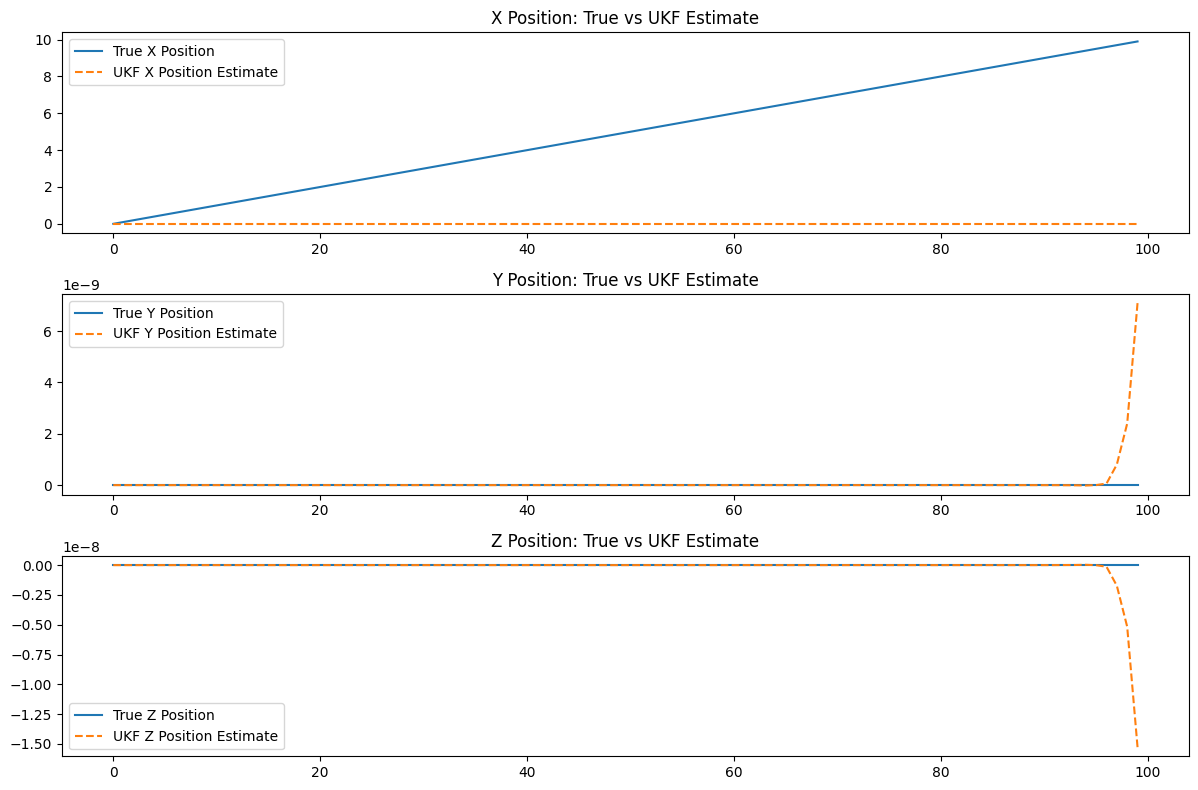

In [ ]:
# Plot the results for comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Compare true position and UKF estimated position
plt.subplot(3, 1, 1)
plt.plot(true_state[:, 0], label='True X Position')
plt.plot(ukf_estimates[:, 0], label='UKF X Position Estimate', linestyle='--')
plt.title('X Position: True vs UKF Estimate')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(true_state[:, 1], label='True Y Position')
plt.plot(ukf_estimates[:, 1], label='UKF Y Position Estimate', linestyle='--')
plt.title('Y Position: True vs UKF Estimate')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(true_state[:, 2], label='True Z Position')
plt.plot(ukf_estimates[:, 2], label='UKF Z Position Estimate', linestyle='--')
plt.title('Z Position: True vs UKF Estimate')
plt.legend()

plt.tight_layout()
plt.show()